I'm looking for the wealthiest neighborhoods/streets in Detroit that have elderly homeowners residing

In [89]:
import geopandas as gp
import requests
import pandas as pd
from tqdm import tqdm

API_KEY = "3918c4d1d4ea6258fc7e150180733f49111ae482"
year = 2018

group = {
    "Estimate!!Total!!Male!!65 to 74 years":"B01001A_014E",
    "Estimate!!Total!!Male!!75 to 84 years":"B01001A_015E",
    "Estimate!!Total!!Male!!85 years and over":"B01001A_016E",
    "Estimate!!Total!!Female!!65 to 74 years":"B01001A_029E",
    "Estimate!!Total!!Female!!75 to 84 years":"B01001A_030E",
    "Estimate!!Total!!Female!!85 years and over":"B01001A_031E",
}

In [49]:
gdf = gp.read_file('detroit.shp')
gdf['percent_owner'] = gdf.OWNER_OCCU/(gdf.OWNER_OCCU+gdf.RENTER_OCC)*100

In [200]:
gdf = gdf.to_crs(epsg=3857)

In [50]:
gdf.iloc[0]

GEO_ID                                                 26163562600
NAME                     Census Tract 5626, Wayne County, Michigan
TOTAL_POPU                                                    3617
MEDIAN_HOU                                                  106563
MEDIAN_HOM                                                  321200
RENTER_OCC                                                     514
OWNER_OCCU                                                    1182
geometry         POLYGON ((-83.486869 42.382782, -83.466465 42....
percent_owner                                              69.6934
Name: 0, dtype: object

In [79]:
def get_acs_data(geo_id):
    geo_id = str(geo_id)
    tract = geo_id[5:]
    county = geo_id[2:5]
    state = geo_id[:2]
    url = f"https://api.census.gov/data/{year}/acs/acs5/?get=NAME,{','.join([y for x,y in group.items()])}&for=tract:{tract}&in=state:{state}&in=county:{county}&key={API_KEY}"
#     print(url)
    response = requests.get(url)
    cols = []
    inv_map = {v: k for k, v in group.items()}
    for record in response.json()[0]:
        if record in inv_map:
            cols.append(inv_map[record])
        else:
            cols.append(record)
    cols
    df = pd.DataFrame([response.json()[1]], columns=cols)
    df["GEO_ID"] = int(geo_id)
    return df[["GEO_ID"]+[n for n,i in group.items()]]

In [98]:
# df_ages = pd.DataFrame(columns=["GEO_ID"]+[n for n,i in group.items()])
for n, row in tqdm(gdf[232:].iterrows()):
    geo_id = row.GEO_ID
    df_ages = df_ages.append(get_acs_data(geo_id), ignore_index=True)

1018it [32:16,  1.90s/it]


In [159]:
# gdf = gdf.merge(df_ages, on="GEO_ID")
# for n,i in group.items():
#     gdf[n] = pd.to_numeric(gdf[n])
gdf["total_elderly_pop"] = gdf[[n for n,i in group.items()]].sum(axis=1)
gdf["percent_elderly_pop"] = gdf["total_elderly_pop"]/gdf["TOTAL_POPU"]*100
gdf.rename(columns={'MEDIAN_HOU': 'median_household_income', 'MEDIAN_HOM': 'median_home_value'}, inplace=True)

In [160]:
gdf.to_file("detroit_with_ages.shp")

c:\users\art perkitny\anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [163]:
gdf[['GEO_ID',"median_home_value","median_household_income","percent_owner","percent_elderly_pop"]].head()

,GEO_ID,median_home_value,median_household_income,percent_owner,percent_elderly_pop
0,26163562600,321200.0,106563.0,69.693396,11.915952
1,26099230700,206700.0,76288.0,95.071259,15.145306
2,26099224500,174600.0,70104.0,89.514218,17.809222
3,26125132600,425600.0,119954.0,98.164514,18.196683
4,26163583600,83100.0,51456.0,85.154639,18.412943


In [206]:
num_records = int(round(len(gdf)*0.15,0))

top_median_home_value = gdf.sort_values("median_home_value", ascending=False).GEO_ID[:num_records]
top_median_household_income = gdf.sort_values("median_household_income", ascending=False).GEO_ID[:num_records]
top_percent_ownere = gdf.sort_values("percent_owner", ascending=False).GEO_ID[:num_records]
top_percent_elderly_pop = gdf.sort_values("percent_elderly_pop", ascending=False).GEO_ID[:num_records]

lists = [top_median_home_value, top_median_household_income, top_percent_ownere, top_percent_elderly_pop]
ids = set.intersection(*map(set,lists))

id_gdf = gp.GeoDataFrame(ids, columns=["GEO_ID"])
id_gdf = id_gdf.merge(gdf[['GEO_ID','geometry']], on="GEO_ID")
print(len(id_gdf))

22


In [208]:
gdf.loc[gdf["GEO_ID"].isin(list(ids))][['GEO_ID',"median_home_value","median_household_income","percent_owner","percent_elderly_pop"]]

,GEO_ID,median_home_value,median_household_income,percent_owner,percent_elderly_pop
10,26163550900,481200.0,154722.0,91.903915,24.874372
51,26125154500,524800.0,171023.0,97.322468,19.055375
53,26125158000,430400.0,137679.0,97.281831,19.206939
54,26163550600,576500.0,180455.0,96.256039,18.568421
58,26125150500,408400.0,155664.0,97.516099,22.043011
67,26093742900,390300.0,123261.0,98.039216,19.040287
69,26099223900,267400.0,105997.0,99.489633,20.276110
73,26163551700,292500.0,110375.0,97.803922,20.716034
78,26099225400,315600.0,113333.0,94.549266,20.651887
93,26099215200,342900.0,122708.0,92.037471,24.105734


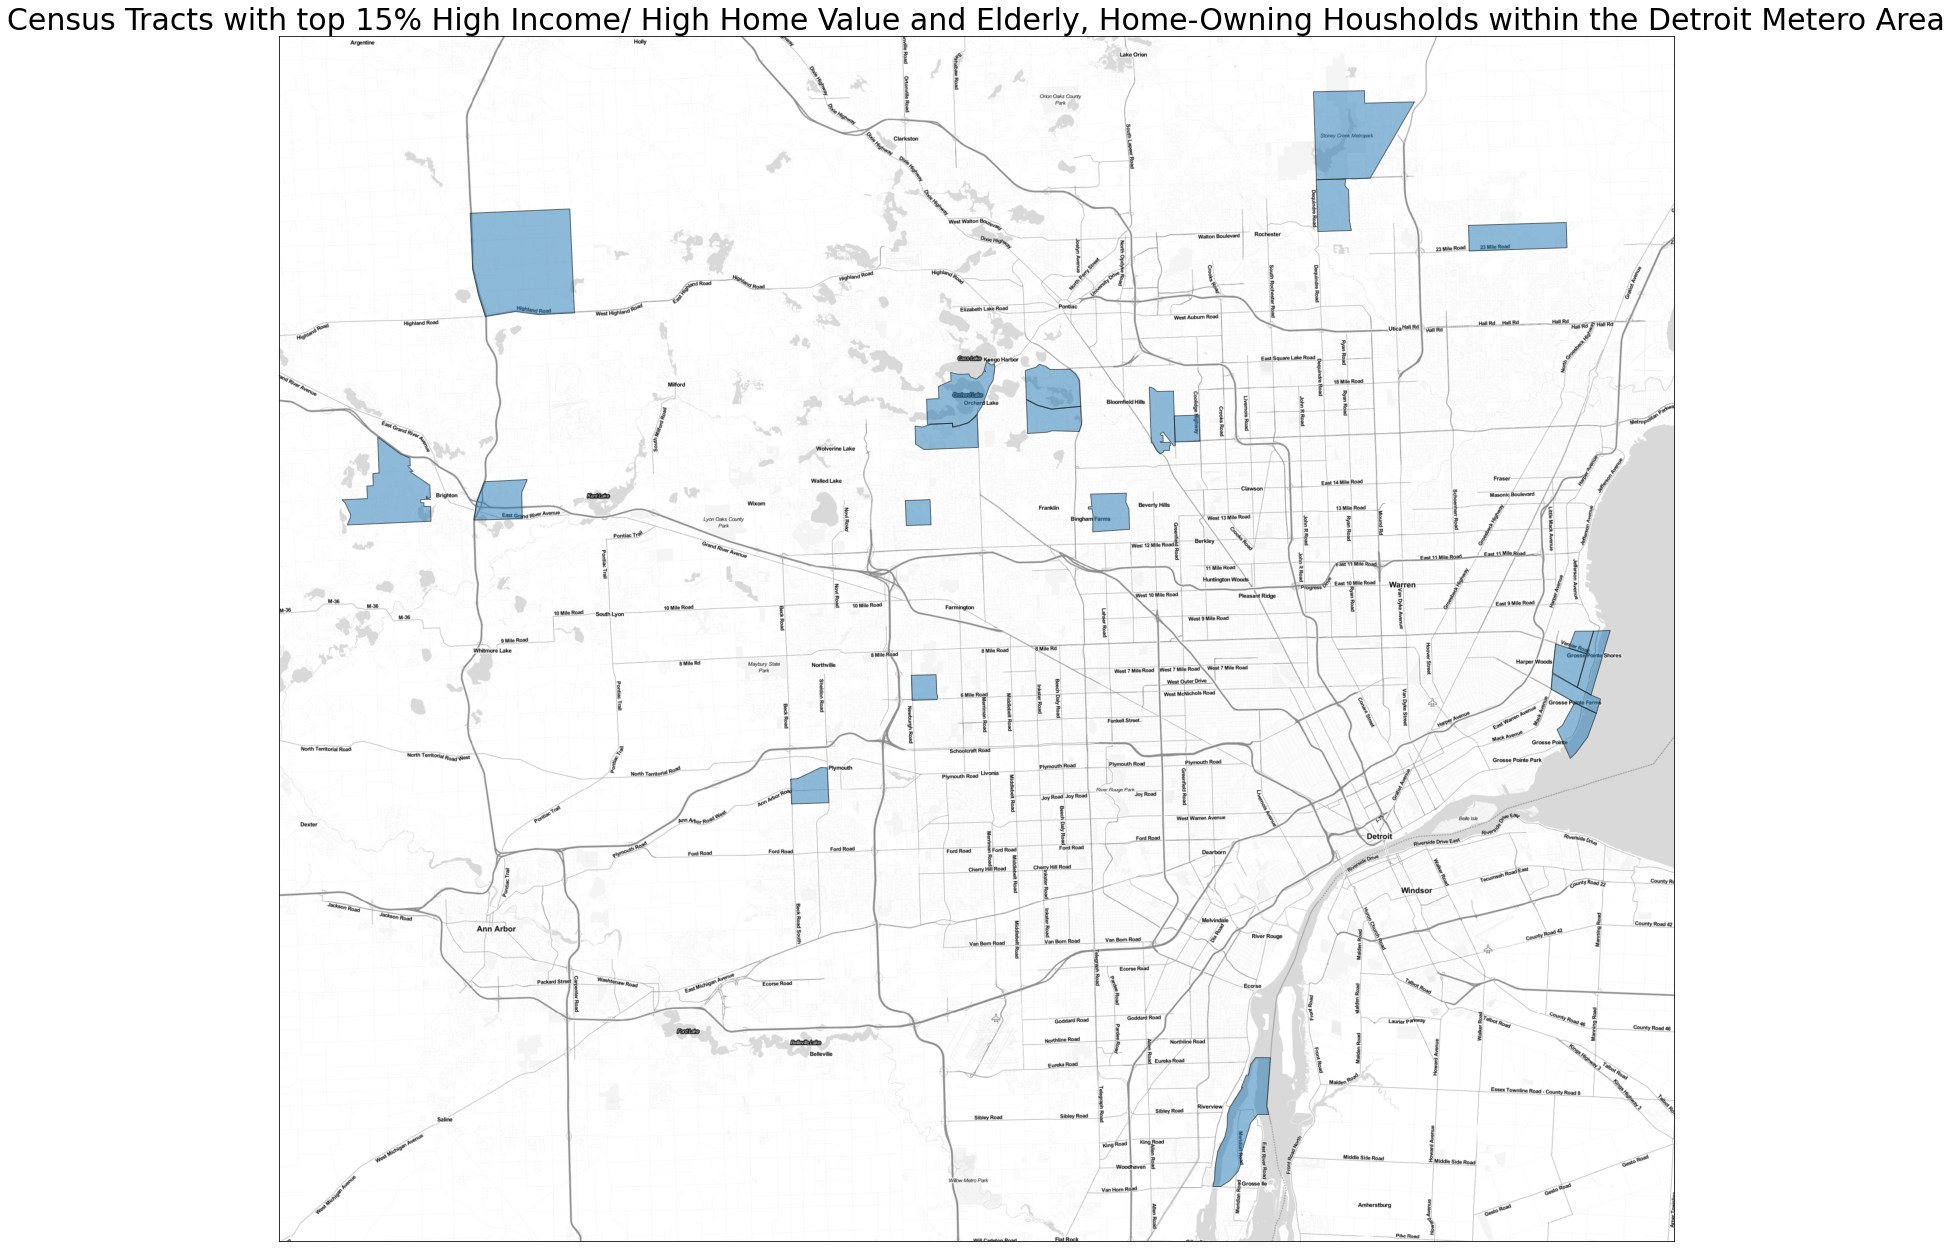

In [211]:
import matplotlib.pyplot as plt
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    ax.axis((xmin, xmax, ymin, ymax))

# column = "price_to_rent"
title = "Census Tracts with top 15% High Income/ High Home Value and Elderly, Home-Owning Housholds within the Detroit Metero Area"
# vmin = states_gdf[column].min()
# vmax = states_gdf[column].max()

ax = id_gdf.plot(
#     column=column,
#     cmap=CMAP,
    figsize=(25, 25),
    alpha=0.5,
    edgecolor='black',
    linewidth=1,
)

add_basemap(ax, zoom=12, url=ctx.sources.ST_TONER_LITE)

# ax.set_xlim(-19000000, -7000000)
# ax.set_ylim(1750000, 10000000)

fig = ax.get_figure()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.set_title(title, fontdict={'fontsize': 30, 'fontweight': 'medium'})

plt.savefig('image.jpg'.format(title),  dpi=300, bbox_inches = "tight")
plt.show()